In [1]:
#%matplotlib inline
import tensorflow as tf
import numpy as np
#import matplotlib.pyplot as plt
from dataset import Dataset
from dataset import DataLoader
from model import *

from scipy.spatial.distance import cdist
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from functools import reduce

In [2]:
loader = DataLoader('../../data/',['t2tsetra/t/40x40x1/'])
loader.load_data()
X,y = loader.get_data('t2tsetra/t/40x40x1/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
X_train = X_train / 255
X_test = X_test / 255


In [4]:
dataset = Dataset()

In [5]:
dataset.images_train = X_train
dataset.images_test = X_test
dataset.labels_train = y_train
dataset.labels_test = y_test


In [6]:
#helper function to plot image
def show_image(idxs, data):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
    fig = plt.figure(figsize = (18,10))
    gs = gridspec.GridSpec(1,len(idxs))
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(data[idxs[i],:,:,0],cmap = 'gray')
        ax.axis('off')
    plt.show()

## Create the siamese net feature extraction model

In [7]:
img_placeholder = tf.placeholder(tf.float32, [None] + list(dataset.images_train.shape[1:]), name='img')
net = mnist_model(img_placeholder, reuse=False)

## Restore from checkpoint and calc the features from all of train data

In [7]:
#run the train image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    train_feat = sess.run(net, feed_dict={img_placeholder:dataset.images_train})

INFO:tensorflow:Restoring parameters from model/model.ckpt


In [8]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    search_feat = sess.run(net, feed_dict={img_placeholder:dataset.images_test})
    

INFO:tensorflow:Restoring parameters from model/model.ckpt


## Count similarity

In [31]:
y_pred = []
for idx,feat in enumerate(train_feat[:30]):
    #calculate the cosine similarity and sort
    print(dataset.labels_test[idx])
    print(siamese_accuracy(train_feat,feat,dataset))
    

0
(array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0]), {0: 80.0, 1: 20.0})
0
(array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0]), {1: 50.0, 0: 50.0})
0
(array([0, 1, 0, 1, 0, 0, 1, 1, 0, 1]), {0: 50.0, 1: 50.0})
0
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), {0: 100.0})
0
(array([0, 1, 0, 1, 0, 1, 0, 1, 1, 0]), {0: 50.0, 1: 50.0})
0
(array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0]), {1: 30.0, 0: 70.0})
1
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), {0: 100.0})
0
(array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), {0: 90.0, 1: 10.0})
0
(array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0]), {1: 50.0, 0: 50.0})
0
(array([0, 0, 1, 1, 0, 1, 0, 1, 0, 1]), {0: 50.0, 1: 50.0})
1
(array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]), {0: 90.0, 1: 10.0})
0
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]), {0: 90.0, 1: 10.0})
1
(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]), {0: 90.0, 1: 10.0})
0
(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]), {0: 90.0, 1: 10.0})
1
(array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0]), {1: 30.0, 0: 70.0})
0
(array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0]), {0: 90.0, 1: 10.0})
0
(array([0, 1, 0, 0, 1,

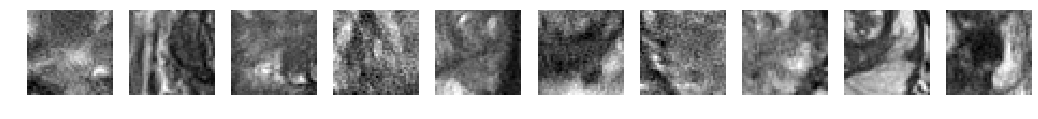

In [10]:
show_image(rank[:10], dataset.images_train)

In [11]:
dataset.labels_train[rank[:10]]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [13]:
dataset.labels_test[-1]

0

In [29]:
def siamese_accuracy(train_feat, search_feat, dataset):
    n = 10
    dist = cdist(train_feat, [feat], 'cosine')
    rank = np.argsort(dist.ravel())
    
    labels = dataset.labels_train[rank[:n]]
    c = Counter(labels) 
    return labels,dict([(i, c[i] / len(labels) * 100.0) for i in c])
    

In [16]:
from collections import Counter
l = [1, 1, 2, 2, 2, 2, 2, 3, 4, 10, 10, 10, 10, 10]
c = Counter(l)
[(i, c[i] / len(l) * 100.0) for i in c]

[(1, 14.285714285714285),
 (2, 35.714285714285715),
 (3, 7.142857142857142),
 (4, 7.142857142857142),
 (10, 35.714285714285715)]

In [56]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()


In [57]:
dataset = Dataset()

In [58]:
dataset.images_train = X_train
dataset.images_test = X_test
dataset.labels_train = y_train
dataset.labels_test = y_test

In [72]:
a,b,c = dataset.get_siamese_batch(4)

In [73]:
len(a)

4

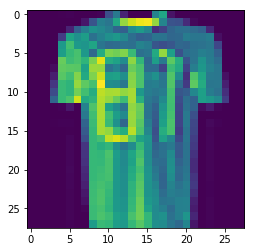

In [74]:
plt.imshow(a[0])

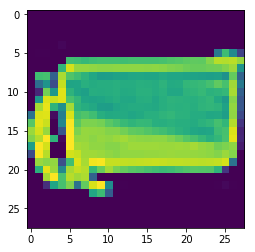

In [75]:
plt.imshow(b[0])

In [77]:
c[0][0]

0